# Current work in progress
    This is a standard no frills GAN with the exception the noise data is the shape of the current image batch. So you can use the standard gausian noise or actual images to train the GAN. 
    Current "experiement is training the GAN on one set of data and the discriminator on real world photos. I want to see what will happen essentially. 
    
### Data Science and Machine Learning is 80% experiementation and "seeing what happens". 
    Sure I could follow exactly what everyone else does but that doesn't benefit me or learning. 

## **Mount Google Drive to store files & data**

In [1]:
!nvidia-smi

Thu Oct  6 00:18:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 83%   76C    P8    51W / 350W |   1493MiB / 12288MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install tensorflow_addons 

## **1) Importing Python Packages for GAN**


In [3]:
# Standard imports 

import sys
import os
from os.path import join, exists
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import random
import time
from IPython import display
#from matplotlib import cm
#import cv2

D:\Anaconda3\envs\ai\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Machine learning Imports. 

# from keras.datasets import cifar10, mnist
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten, GlobalAveragePooling1D 
from tensorflow.keras.layers import Conv2D, Dense, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
# look this shit up.
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()

# Config Class
*Because it's cleaner avoids messy globals and scope ambiguity. 

In [5]:
class Config:
    gan_name = "AnimeHorrorGan"
    
    runningColab = False
    windows_base_path = "F:\\machine_learning"
    colab_base_path = "/content/drive/MyDrive/TensorFlow"
    
    # Migrating to training generator on horror
    # and discriminator on real images. Seeing if it will transpose or fail. 
    dataset = "current_dataset"
    save_loc = "generated_images"
    test_images_path = "F:\machine_learning\datasets\cats_dataset"
    test_images = []

    # Final location defaults.
    # gets overwritten depending on Colab or Local. 
    model_save_path = f"{windows_base_path}\\my_models"
    dataset_path = join(windows_base_path, "datasets", dataset) # iput

    
    # I should save generated images in a different dir. This was due to ADHD. 
    generated_path = join(windows_base_path, "datasets", save_loc) # output
    
    generator_file = join(model_save_path, f"{gan_name}_generator.h5")
    discriminator_file = join(model_save_path, f"{gan_name}_discriminator.h5")

    batch_size = 5

    img_width = 512
    img_height = 512
    channels = 3
    img_shape = (img_width, img_height, channels)

    latent_dim = 100 # Not really used anymore.
    seed = 42
    
    files = []
    batches_per_epoch = 0

In [6]:
if 'google.colab' in sys.modules:
    Config.runningColab = True
print ('Running in colab:', Config.runningColab)

Running in colab: False


In [7]:
if Config.runningColab:
    from google.colab import drive
    drive.mount('/content/drive')

In [8]:
# Bit more work switching between local and Colab
if Config.runningColab:
    Config.generated_path = join(Config.colab_base_path, "datasets", Config.save_loc) # output
    Config.dataset_path = join(Config.colab_base_path, "datasets", Config.dataset)
    Config.model_save_path = join(Config.colab_base_path, "models")
else:
    Config.generated_path = join(Config.windows_base_path, "datasets", Config.save_loc) # output
    Config.dataset_path = join(Config.windows_base_path, "datasets", Config.dataset)
    Config.model_save_path = join(Config.windows_base_path, "my_models")

In [9]:
Config.dataset_path

'F:\\machine_learning\\datasets\\current_dataset'

In [10]:
if not exists(Config.generated_path):
    print(f"Creating {Config.generated_path}")
    os.mkdir(Config.generated_path)

## **2) Parameters for Neural Networks & Data**

## **Function Defs**

In [11]:
def plant_seeds(seed=42):
    Config.seed = seed
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
plant_seeds(int(time.time()))

In [12]:
def make_noise(num_images_to_gen):
    # num_images_to_gen long way to say "Batch size". 
    #result = tf.random.normal(shape=[num_images_to_gen, latent_dim])
    #result = tf.random.normal(shape=[num_images_to_gen, Config.img_width, Config.img_height, Config.channels], mean=0.0, stddev=1)
    result = tf.random.uniform(shape=[num_images_to_gen, Config.img_width, Config.img_height, Config.channels], minval=-1.0, maxval=1.0, seed=Config.seed)
    return result

In [13]:
# for cropping, will probably use this for all images since this is resizing and creating new hash. 
def name_image(img):
    hashedImage = hashlib.md5(img.tobytes()).hexdigest()
    hashedName = hashedImage + "." + "jpg"
    return hashedName

In [14]:
# Decode a single image in a TFRecord
# It also standardizes the image
# Not really needed since this is done in Numpy
def decode_image(image) -> tf.Tensor:
    #img = (tf.cast(image, tf.float32) / 127.5) - 1
    img = image / 127.5 - 1
    print(type(img))
    img = tf.reshape(img, [Config.img_width, Config.img_height, Config.channels])
    #print(img.shape)
    return img

In [15]:
# This is technically how you're supposed to do it. 
# I don't use this function.
def dataset_from_dir(dataset_folder, ordered=False):
    dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_folder,
        labels=None,
        #validation_split=0.2,
        #subset="training",
        shuffle = False,
        seed=Config.seed,
        image_size=(Config.img_height, Config.img_width),
        batch_size=1)
    dataset = dataset.map(decode_image)
    dataset = dataset.cache()
    #dataset.shuffle(2048)
    return dataset.batch(Config.batch_size)

In [16]:
# Memory intensive. Use load_batch instead. 
# Loads it all into memory. Not Colab friendly. Works if you got 32G or more RAM. 
def dataset_manual(dataset_folder, max=0):
    Config.imageNames = os.listdir(Config.dataset_path)
    if max > 0:
        imageNames = imageNames[:max]
        print(f"using {len(imageNames)} images.")
    array = []
    for image in imageNames:
        image = Image.open(join(resized_path, image))
        data = np.asarray(image)
        array.append(data)

    X_train = np.array(array)
    X_train = X_train / 127.5 -1.
    print(X_train.shape)
    return X_train

In [17]:
def get_images_list(path):
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        # Granted by the time I've created a dataset, there should only be jpg
        # I may go png and just open with a .convert("RGB") call later on. 
        for file in f:
            if '.jpg' in file.lower() or '.png' in file.lower():
                files.append(os.path.join(r, file))
    return files

In [18]:
# Colab was running out of memory because loading all the datasets into memory burned out the VM. This solves that.
# It was also easier to do it this way than the above creating datasets stuff. 
def load_batch(files, batchSize):
    array = []
    for i in range(batchSize):
        # if there is less than 3 color channels, keep trying. 
        while True:
            file = random.choice(files)
            if not exists(file):
                get_list_build_batches() # sometimes I'll just delete stuff while it's running. 
                continue
            try:
                image = Image.open(file).convert("RGB")
            except:
                file = random.choice(files)
                image = Image.open(file)
                print(f"Something occurred with {file}")
                
            if image.size != (Config.img_width, Config.img_height): # not messing around. It doesn't fit, we'll make it fit. 
                print(f"Resizing rogue image {file}.")
                image = image.resize((Config.img_width, Config.img_height))
                image.save(file)
            if len(image.split()) != 3:
                print(f"Removing {file}")
                os.remove(file)
                get_list_build_batches()
            else:
                break
        data = np.asarray(image)
        data = data / 127.5 -1.
        #print(data)
        array.append(data)

    train = np.array(array, dtype=np.float32)
    return train

In [19]:
# Everyon's showe off their data code looks the same. :-p
def show_batch(image_batch):
    total_images = Config.batch_size
    col_row = int(total_images/2)

    plt.figure(figsize=(col_row,col_row))
    for n in range():
        ax = plt.subplot(10,10,n+1)
        plt.imshow(image_batch[n, :, :, 0], cmap='gray')
        plt.axis("off")

In [20]:
def save_image(name, source):
    image = Image.fromarray(np.uint8(source*255))
    image.save(name)

In [21]:
def get_list_build_batches():
    print(f"Getting file list and factoring how many batches per Epoch.")
    Config.files = get_images_list(Config.dataset_path)
    epoch_batches = int(len(Config.files) / Config.batch_size )
    epoch_batches = epoch_batches - (epoch_batches % Config.batch_size)
    Config.batches_per_epoch = epoch_batches - (epoch_batches % Config.batch_size)
    #return imageFiles, epoch_batches

# **Load and visualize the dataset**

### Counts how many batches per epoch will be used. Important really. 

In [22]:
# Builds list of images into array. Reduces file IO.
#Config.imageFiles, Config.batches_per_epoch = get_list_build_batches()
Config.test_images = get_images_list(Config.test_images_path)

# batches based on generator dataset. 
get_list_build_batches()
print(Config.batches_per_epoch)

Getting file list and factoring how many batches per Epoch.
2830


### Visualization stuff. Can be skipped. 

In [23]:
images = load_batch(Config.files, Config.batch_size)
#images = load_batch(Config.test_images, Config.batch_size)

In [24]:
## Test the image manipulation and formatting here. 

In [25]:
images.shape

(5, 512, 512, 3)

In [26]:
print(images.min(), images.max())

-1.0 1.0


In [27]:
images = (images + 1) / 2.0 # Changed from -1...1 to 0...1 for plt and save to work. 

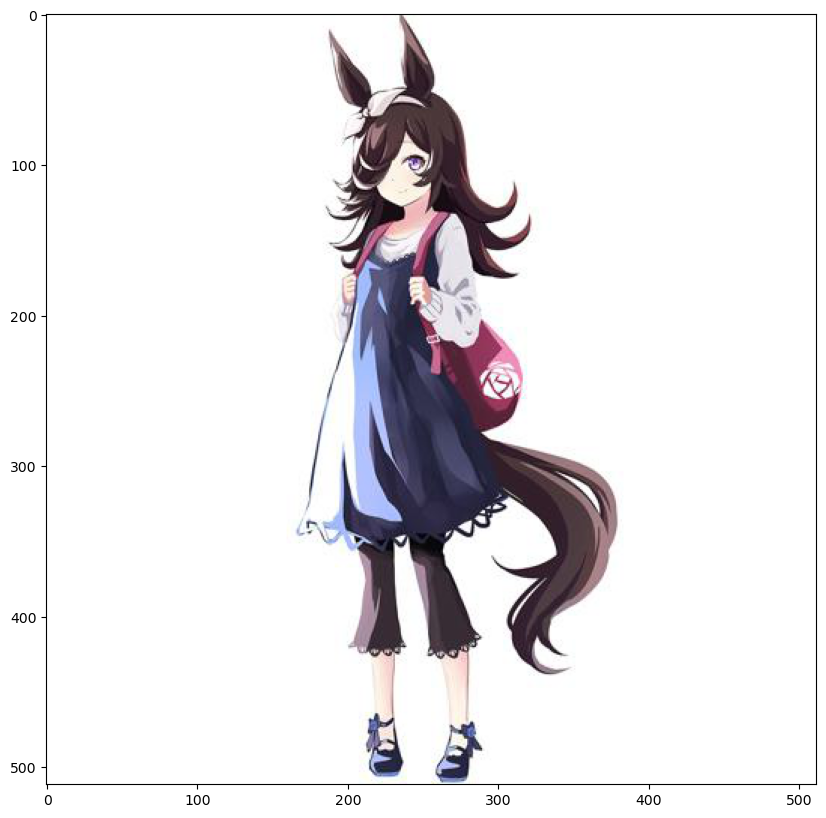

In [28]:
image = random.choice(images)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()
#save_image("batch_test.png", image)

In [29]:
#X_train = dataset_from_dir(Config.dataset_path) 
#epoch_batches = len(X_train)

## **Functions to build Gen/Disc**

In [30]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)) # Could also use batch normalization.

    result.add(layers.LeakyReLU())

    return result

In [31]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

## **3) Building Generator**





In [32]:
# This one is OK, but it takes a flat noise and does things to make images. I've trained 200 epochs and still get junk. 
def Generator1():
    multiplyer = int(((img_width/2)/2/2))
    model = Sequential(name="Generator")
    model.add(Dense(img_width * multiplyer * multiplyer, input_dim=latent_dim)) # img_width was 256 here. 
    model.add(LeakyReLU(alpha=0.3))
    model.add(Reshape((multiplyer,multiplyer,img_width))) # img_width was 256 here. 
    
    #model.add(BatchNormalization()) # Added
    
    model.add(Conv2DTranspose(128, (4,4), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.3)) # activation leakey instead of old fashion RelU

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (2,2), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.3))
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [33]:
# When building an image generator, it just makes sense they'd take in noise or an image of the same size it generates. 
def Generator2(width=512, height=512, channels=3):
    inputs = layers.Input(shape=(width, height, channels))

    # bs = batch size
    # Conv2D
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(64, 4), # (bs, 64, 64, 128) # added
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    # convTranspose
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
        upsample(64, 4), # (bs, 128, 128, 128) # added
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(channels, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x, name="Generator")

In [34]:
def Generator3(width=512, height=512, channels=3):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*1024, use_bias=False, input_shape=(None, width, height, channels)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 1024)))
    assert model.output_shape == (None, 7, 7, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 56, 56, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(2, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

## **4) Building Discriminator**

In [35]:
def Discriminator1():
    model = Sequential(name="Discriminator")
    model.add(Conv2D(64, (3,3), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Conv2D(128, (3,3), padding='same', ))
    model.add(LeakyReLU(alpha=0.3))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Conv2D(filters=256, kernel_size=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.3))
    
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [36]:
def Discriminator2(width=512, height=512, channels=3):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=(width, height, channels), batch_size=None)

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)

    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    last = Flatten()(last)
    #last = Dropout(0.4)(last)
    last = Dense(1, activation='sigmoid')(last)

    return tf.keras.Model(inputs=inp, outputs=last, name="Discriminator")

In [37]:
def Discriminator3(width=512, height=512, channels=3):
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(filters=64, kernel_size=1, strides=(2, 2), padding='same', input_shape=(width, height, channels)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filters=128, kernel_size=1, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(filters=256, kernel_size=1, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(filters=512, kernel_size=1, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #model.add(layers.Flatten())
    model.add(GlobalAveragePooling1D (keepdims=False))
    model.add(layers.Dense(1))

    return model


In [38]:
# Old way.
#generator = Generator1()
#discriminator = Discriminator1()

In [39]:
generator = Generator2(Config.img_width, Config.img_height, Config.channels)
discriminator = Discriminator2(Config.img_width, Config.img_height, Config.channels)

In [40]:
#generator = Generator3(Config.img_width, Config.img_height, Config.channels)
#discriminator = Discriminator3(Config.img_width, Config.img_height, Config.channels)

In [41]:
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 128, 128, 64  65664       ['sequential[0][0]']             
                                )                                                         

In [42]:
#generator.trainable_variables

In [43]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 sequential_17 (Sequential)  (None, 256, 256, 64)      3072      
                                                                 
 sequential_18 (Sequential)  (None, 128, 128, 128)     131328    
                                                                 
 sequential_19 (Sequential)  (None, 64, 64, 256)       524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, 66, 66, 256)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 63, 63, 512)       2097152   
                                                     

In [44]:
#discriminator.trainable_variables

In [45]:
# Optimizer stuff. Moved down here to be closer where it is used. 

# adam = Adam(learning_rate=0.002) # Default is 0.001

# optimization level is different for each model. 
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

cross_entropy = BinaryCrossentropy(from_logits=False)
loss = BinaryCrossentropy(from_logits=False)

In [46]:
discriminator.compile(loss=loss, optimizer=discriminator_optimizer, metrics=['accuracy'])
#discriminator.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE), optimizer=adam, metrics=['accuracy'])
#discriminator.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=adam, metrics=['accuracy'])

discriminator.trainable = False # Set to false before compiling main GAN.

## **5) Connecting Neural Networks to build GAN**

In [47]:
GAN = Sequential(name=Config.gan_name)
GAN.add(generator)
GAN.add(discriminator)
GAN.summary()

GAN.compile(loss=loss, optimizer=generator_optimizer)

Model: "AnimeHorrorGan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Functional)      (None, 512, 512, 3)       54611843  
                                                                 
 Discriminator (Functional)  (None, 1)                 2769414   
                                                                 
Total params: 57,381,257
Trainable params: 54,611,843
Non-trainable params: 2,769,414
_________________________________________________________________


In [48]:
#generator.summary()
#discriminator.summary()

### Loss functions

In [49]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [50]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Saving

In [51]:
def save_backup(disc, gen):
    print("Saving backup weights...")
    backup_gen_file = join(Config.model_save_path, f"{Config.gan_name}_generator_{Config.seed}.h5")
    backup_disc_file = join(Config.model_save_path, f"{Config.gan_name}_discriminator_{Config.seed}.h5")
    generator.save_weights(backup_gen_file)
    discriminator.save_weights(backup_disc_file)

In [52]:
def load_progress(disc, gen):
    if exists(Config.generator_file):
        print("Loading generator weights.")
        gen.load_weights(Config.generator_file)
    if exists(Config.discriminator_file):
        print("Loading discriminator weights.")
        disc.load_weights(Config.discriminator_file)
    
    # if nothing loads it just returns the same model. 
    return disc, gen

In [53]:
def save_progress(disc, gen):
    gen.save_weights(Config.generator_file)
    disc.save_weights(Config.discriminator_file)
    

## Generating Images


In [54]:
def test_generator(epoch):
    #generator, discriminator = GAN.layers
    num_to_gen = 8
    noise = make_noise(num_to_gen)
    #noise = load_batch(Config.test_images, num_to_gen)
    
    gen_imgs = generator(noise, training=False)
    gen_imgs = (gen_imgs + 1) / 2.0

    # Rescale images 0 - 1
    print(f"Generating {num_to_gen} test images.")

    for i in range(num_to_gen):
        save_image(f"{Config.generated_path}/{epoch}_{Config.gan_name}_{i}.jpg", gen_imgs[i])


## **7) Training GAN**

In [55]:
def train(epochs, batch_size=32):
    # Grab the seprate components
    generator, discriminator = GAN.layers
    
    print(f"training starting with {epochs} epochs of {Config.batches_per_epoch} total batches each. Batch size is {batch_size}")

    #Create our Y for our Neural Networks
    valid = np.ones((batch_size, 1))
    fakes = np.zeros((batch_size, 1))
    
    discriminator, generator = load_progress(discriminator, generator)
    
    for epoch in range(epochs):
        epoch_batches = Config.batches_per_epoch # If it changes. 
        for j in range(epoch_batches):

            #Phase 1: Generate fake images.
            noise = make_noise(batch_size)
            real_imgs = load_batch(Config.files, batch_size) #Get Random Batch
            
            # training_step usually a function. But really, easier to follow and adjust here. 
            #Phase 2: Train discriminator
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_imgs = generator(noise, training=True)

                discriminator.trainable = True # I think we forgot this so it never trained, ever. 
                loss_real = discriminator.train_on_batch(real_imgs, valid)
                loss_fake = discriminator.train_on_batch(fake_imgs, fakes)
                #loss_real = discriminator(real_imgs, training=True)
                #loss_fake = discriminator(fake_imgs, training=True)
                
                noise = make_noise(batch_size)
                gan_loss = GAN.train_on_batch(noise, valid)
                
                d_loss = discriminator_loss(loss_real, loss_fake)
                g_loss = generator_loss(loss_fake)
                
                loss = 0.5 * np.add(loss_real, loss_fake)
                accuracy = (100 * loss[1])
                
            discriminator.trainable = False
            # Adjust optimizer learning rates. 
            #gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
            #gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)

            #generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            

            # Phase 3: feed fake images to generator and set labels as "real". 
            #gen_train_imgs = load_batch(Config.gen_files, batch_size)
            #noise = make_noise(batch_size)
            #g_loss = GAN.train_on_batch(noise, valid)
            
            
            if j % 50 == 0:
                print(f"******* Epoch: {epoch+1}/{epochs}: Batch {j}/{epoch_batches} [D loss: {d_loss:.6f}, acc: {accuracy:.2f}%] [G loss: {g_loss:.6f}]")

        print(f"Saving weights: {generator_file}")
        save_progress(discriminator, generator)

        # Sometimes I get a really great training and then later Epochs it gets wrecked. 
        # So I save every X epochs. 
        # **** This will take up a lot of disk space. 
        if epoch % 50 == 0:
            display.clear_output(wait=True)
            save_backup(discriminator, generator)
        
        test_generator(epoch+1)
        
        # Adding a seed after every epoch makes results close to impossible to reproduce. 
        # Seed is saved as part of the backup model name, so that's a start. 
        plant_seeds(int(time.time())) # New seedlings every Epoch. 
        
    print("Training Done!")

In [56]:
startover = True
if startover:
    generator_file = join(Config.model_save_path, f"{Config.gan_name}_generator.h5")
    discriminator_file = join(Config.model_save_path, f"{Config.gan_name}_discriminator.h5")

    print("Removing saved models.")
    if exists(generator_file):
        # Gonna assume it's 2 for one.
        os.remove(generator_file)
        os.remove(discriminator_file)

Removing saved models.


In [ ]:
train(500, batch_size=Config.batch_size)

Saving backup weights...
Generating 8 test images.
******* Epoch: 2/500: Batch 0/2830 [D loss: 2.150253, acc: 80.00%] [G loss: 0.386442]
******* Epoch: 2/500: Batch 50/2830 [D loss: 8.730415, acc: 100.00%] [G loss: 1.303331]
******* Epoch: 2/500: Batch 100/2830 [D loss: 10.770000, acc: 100.00%] [G loss: 3.603201]
******* Epoch: 2/500: Batch 150/2830 [D loss: 10.072247, acc: 100.00%] [G loss: 2.700274]
******* Epoch: 2/500: Batch 200/2830 [D loss: 13.207660, acc: 100.00%] [G loss: 3.103777]
******* Epoch: 2/500: Batch 250/2830 [D loss: 10.820971, acc: 100.00%] [G loss: 1.202908]
******* Epoch: 2/500: Batch 300/2830 [D loss: 1.492678, acc: 80.00%] [G loss: 0.472601]
******* Epoch: 2/500: Batch 350/2830 [D loss: 9.336918, acc: 100.00%] [G loss: 2.173943]
******* Epoch: 2/500: Batch 400/2830 [D loss: 8.481830, acc: 60.00%] [G loss: 1.937269]
******* Epoch: 2/500: Batch 450/2830 [D loss: 9.376173, acc: 100.00%] [G loss: 1.266065]
******* Epoch: 2/500: Batch 500/2830 [D loss: 14.818407, acc:

### Select this cell. Run all above :-p 

# Scratchpad

In [ ]:
#generator, discriminator = GAN.layers

# Finally made a function. 
discriminator, generator = load_progress(discriminator, generator)

In [ ]:
noise = make_noise(10)
plt.imshow(noise[0])
print(np.array(noise[0]).min(), np.array(noise[0]).max())

In [ ]:
gen_imgs = generator(noise)
print(np.array(gen_imgs[0]).min(), np.array(gen_imgs[0]).max())
gen_imgs = (gen_imgs + 1) / 2.0
print(np.array(gen_imgs[0]).min(), np.array(gen_imgs[0]).max())
#gen_imgs = (gen_imgs * 255.).astype(int)
#gen_imgs = np.clip(gen_imgs, 0, 255)
#print(f"{gen_imgs.shape}\n{gen_imgs}")
#gen_imgs[0]
#save_image("generated.png", gen_imgs[2])



In [ ]:
plt.imshow(gen_imgs[2])

In [ ]:
imgs = load_batch(Config.test_images, num_to_gen)
imgs = np.expand_dims(img, axis=0)
gen = generator(imgs)

#conf prp1158022770

In [ ]:
gen.shape
gen = (gen + 1) / 2.0

In [ ]:
2.3841858e-07

In [ ]:
testimages = load_batch(imageFiles, 10)
testimages.shape

In [ ]:
gen = generator(testimages)
#gen = (gen + 1) / 2.0

In [ ]:
gen.shape

In [ ]:
plt.imshow(random.choice(gen))

In [ ]:
#gen_imgs.shape

In [ ]:
plt.imshow(gen_imgs[6])

In [ ]:
print(gen_imgs.min(), gen_imgs.max())

### **8) Making GIF**

In [ ]:
# Display a single image using the epoch number
# def display_image(epoch_no):
#   return PIL.Image.open('generated_images/%.8f.png'.format(epoch_no))

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated_images/*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)